# <center>  🔭 Exploración y Limpieza de Datos </center>

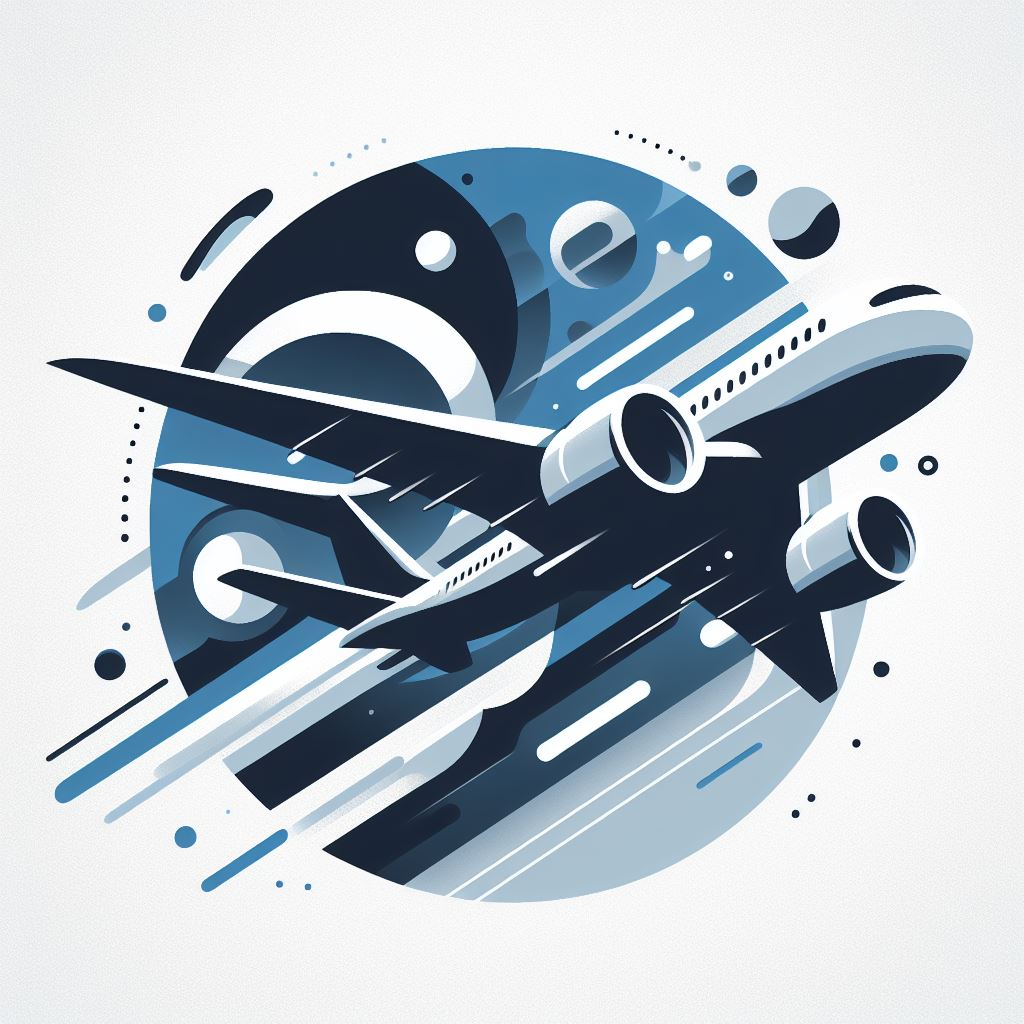

Has sido contratado por la empresa Tokio School Viajes y el objetivo de este puesto de trabajo es analizar un conjunto de datos sobre el tráfico en el aeropuerto de San Francisco, donde salen muchos vuelos camino a Tokio (Japón) y otras ciudades de ese mismo país.
El objetivo es explorar y limpiar el dataset *Air_Traffic_Passenger_Statistics.csv*

***Descripción del DataSet***
| Variable                        | Definición                      |
|---------------------------------|---------------------------------|
| Activity Period                 | Periodo de actividad            |
| Operating Airline               | Aerolínea operativa             |
| Operating Airline IATA Code      | Código IATA de la aerolínea operativa |
| Published Airline               | Aerolínea publicada             |
| Published Airline IATA Code      | Código IATA de la aerolínea publicada |
| GEO Summary                     | Resumen GEO                     |
| GEO Region                      | Región GEO                      |
| Activity Type Code              | Código de tipo de actividad      |
| Price Category Code              | Código de categoría de precio    |
| Terminal                        | Terminal                        |
| Boarding Area                   | Área de embarque                |
| Passenger Count                 | Cantidad de pasajeros            |
| Adjusted Activity Type Code      | Código de tipo de actividad ajustado |
| Adjusted Passenger Count        | Cantidad de pasajeros ajustada    |
| Year                            | Año                             |
| Month                           | Mes                             |


In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import mean, round, std, max, min, col, max

spark = SparkSession.builder.master("local").appName("Data-Exploration").getOrCreate()
spark

In [12]:
# Importo el fichero localizado en la misma ruta del projecto
data = spark.read.options(inferShema='True', delimiter= ',', header=True).csv('work/data/Air_Traffic_Passenger_Statistics.csv')
data.printSchema()

root
 |-- Activity Period: string (nullable = true)
 |-- Operating Airline: string (nullable = true)
 |-- Operating Airline IATA Code: string (nullable = true)
 |-- Published Airline: string (nullable = true)
 |-- Published Airline IATA Code: string (nullable = true)
 |-- GEO Summary: string (nullable = true)
 |-- GEO Region: string (nullable = true)
 |-- Activity Type Code: string (nullable = true)
 |-- Price Category Code: string (nullable = true)
 |-- Terminal: string (nullable = true)
 |-- Boarding Area: string (nullable = true)
 |-- Passenger Count: string (nullable = true)
 |-- Adjusted Activity Type Code: string (nullable = true)
 |-- Adjusted Passenger Count: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)



Al importar el fichero e indicarle en la configuración que realizara la inferencia de datos de forma automática **inferSchema=True**, observo como las columnas han sido inferidas a datos de tipo String, cuando realmente nos encontramos con diversos tipos de datos. Por este motivo, volveré a cargar los datos infiriendo manualmente en el tipo de dato para cada columna.

In [13]:
# Defino el Schema manualmente
custom_schema = StructType([
    StructField("Activity Period", StringType(), True),
    StructField("Operating Airline", StringType(), True),
    StructField("Operating Airline IATA Code", StringType(), True),
    StructField("Published Airline", StringType(), True),
    StructField("Published Airline IATA Code", StringType(), True),
    StructField("GEO Summary", StringType(), True),
    StructField("GEO Region", StringType(), True),
    StructField("Activity Type Code", StringType(), True),
    StructField("Price Category Code", StringType(), True),
    StructField("Terminal", StringType(), True),
    StructField("Boarding Area", StringType(), True),
    StructField("Passenger Count", IntegerType(), True),
    StructField("Adjusted Activity Type Code", StringType(), True),
    StructField("Adjusted Passenger Count", IntegerType(), True),
    StructField("Year", StringType(), True),
    StructField("Month", StringType(), True),
    ])

data = spark.read.schema(custom_schema).option("delimiter", ",").option("header", "true").csv('work/data/Air_Traffic_Passenger_Statistics.csv')
data.printSchema()

root
 |-- Activity Period: string (nullable = true)
 |-- Operating Airline: string (nullable = true)
 |-- Operating Airline IATA Code: string (nullable = true)
 |-- Published Airline: string (nullable = true)
 |-- Published Airline IATA Code: string (nullable = true)
 |-- GEO Summary: string (nullable = true)
 |-- GEO Region: string (nullable = true)
 |-- Activity Type Code: string (nullable = true)
 |-- Price Category Code: string (nullable = true)
 |-- Terminal: string (nullable = true)
 |-- Boarding Area: string (nullable = true)
 |-- Passenger Count: integer (nullable = true)
 |-- Adjusted Activity Type Code: string (nullable = true)
 |-- Adjusted Passenger Count: integer (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)



Tras analizar la tipología del dataset, se observa que la mayoría de las variables son categóricas salvo las variables *Passenger Count* y *Adjusted Passenger Count* las cuales hacen referencia el número de pasajeros. Por ese motivo se han tipificado como variables numéricas.

In [14]:
# Muestro los primeros 10 valores del dataset
data.show(10)

+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|Activity Period|Operating Airline|Operating Airline IATA Code|Published Airline|Published Airline IATA Code|  GEO Summary|         GEO Region|Activity Type Code|Price Category Code|     Terminal|Boarding Area|Passenger Count|Adjusted Activity Type Code|Adjusted Passenger Count|Year|Month|
+---------------+-----------------+---------------------------+-----------------+---------------------------+-------------+-------------------+------------------+-------------------+-------------+-------------+---------------+---------------------------+------------------------+----+-----+
|         200507|     ATA Airlines|                         TZ|     ATA Airlines|                         TZ|     Domestic|    

In [21]:
# Confirmo que el número de filas coincide con el fichero
print(f"Número de filas: {data.count()}")

Número de filas: 15007


In [41]:
# Muestro las diferentes Aerolíneas existentes
category_airline = data.select('Operating Airline').distinct()
category_airline.show()
category_count = data.select('Operating Airline').distinct().count()
print(f"Número de Aerolíneas Únicas: {category_count}")

+--------------------+
|   Operating Airline|
+--------------------+
|          Icelandair|
|         Ameriflight|
|      Cathay Pacific|
|          Aeromexico|
|      Etihad Airways|
| Philippine Airlines|
|United Airlines -...|
|    Turkish Airlines|
| Swiss International|
|    Independence Air|
|Miami Air Interna...|
|          Air France|
|      Japan Airlines|
|    Midwest Airlines|
|      Atlas Air, Inc|
|    JetBlue Airways |
|       China Eastern|
|   Mexicana Airlines|
|         Air Canada |
|       Allegiant Air|
+--------------------+
only showing top 20 rows

Número de Aerolíneas Únicas: 77


In [31]:
# Muestro la média de pasajeros por aerolínea
airline_men = data.groupBy('Operating Airline').agg(
    round(mean('Passenger Count'), 2).alias('Media Pasajeros')
)
airline_men.show()

+--------------------+---------------+
|   Operating Airline|Media Pasajeros|
+--------------------+---------------+
|          Icelandair|         2799.7|
|         Ameriflight|            5.0|
|      Cathay Pacific|       17121.33|
|          Aeromexico|        5463.82|
|      Etihad Airways|        6476.09|
| Philippine Airlines|       10248.64|
|United Airlines -...|       48915.47|
|    Turkish Airlines|        8162.42|
| Swiss International|        6061.64|
|    Independence Air|         6391.3|
|Miami Air Interna...|         107.38|
|          Air France|       11589.08|
|      Japan Airlines|        6470.33|
|    Midwest Airlines|         3883.0|
|      Atlas Air, Inc|           34.0|
|    JetBlue Airways |       35261.14|
|       China Eastern|         5498.4|
|   Mexicana Airlines|        7993.81|
|         Air Canada |       18251.56|
|       Allegiant Air|        1516.81|
+--------------------+---------------+
only showing top 20 rows



In [42]:
# Nos solicitan eliminar los registros duplicados por el campo *Geo Region*, manteniendo únicamente aquel con el mayor númoer de pasajeros
# Realizo una exploración del campo GEO Region para ver las variables únicas
category_geo = data.select('GEO Region').distinct()
category_geo.show()

+-------------------+
|         GEO Region|
+-------------------+
|             Europe|
|    Central America|
|                 US|
|      South America|
|             Mexico|
|        Middle East|
|             Canada|
|Australia / Oceania|
|               Asia|
+-------------------+



In [50]:
# Busco el máximo valor de la categoría 'Passenger Count' para cada 'GEO Region' y renombro la columnas
max_passenger_count = data.groupBy("GEO Region").agg(max("Passenger Count").alias("max_passenger_count"))

# Renombro la columna en max_passenger_count para evitar ambigüedad
max_passenger_count = max_passenger_count.withColumnRenamed("GEO Region", "max_GEO_Region").withColumnRenamed("Passenger Count", "max_Passenger_Count")

# Uno "join" el DataFrame original con los máximos 'Passenger Count'
result_df = data.join(max_passenger_count, (data["GEO Region"] == max_passenger_count["max_GEO_Region"]) & (data["Passenger Count"] == max_passenger_count["max_Passenger_Count"]), "inner")

# Selecciono solo las columnas necesarias después de la unión
result_df = result_df.select('GEO Region','Passenger Count')

# Muestro el resultado
result_df.show()

+-------------------+---------------+
|         GEO Region|Passenger Count|
+-------------------+---------------+
|             Canada|          39798|
|               Asia|          86398|
|      South America|           3685|
|                 US|         659837|
|             Mexico|          29206|
|    Central America|           8970|
|Australia / Oceania|          12973|
|        Middle East|          14769|
|             Europe|          48136|
+-------------------+---------------+



In [48]:
# Guardo en un csv los resultados obtenido en airline_men y result_df
result_df.union(airline_men).write.csv("work/data/Air_Traffic_Passenger_Statistics_explorer.csv.csv", header=True, mode="overwrite")
